# Lithology Prediction with Random Forest

Author: Promise Ekeh

Date: 25/08/2021

This project was for my Msc project at Imperial College London

In [1]:
#%matplotlib notebook
import time
import pandas as pd
import numpy as np
import numpy.random as nr
import random
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from numpy import mean
from collections import Counter

from sklearn import preprocessing

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
import operator
from scipy.signal import savgol_filter
import pywt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from scipy.stats.mstats import winsorize

from sklearn.linear_model import BayesianRidge

In [2]:
sklearn.__version__

'0.23.2'

## FUNCTIONS DEFINITIONS

In [3]:
#Functions for evaluation
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

def evaluate_preds(y_true, y_preds):
    """
    Performs model evaluation  on y_true labels vs. y_pred labels and cross validation on model, X and y
    on a classification.
    """
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average= 'weighted')
    recall = recall_score(y_true, y_preds, average= 'weighted')
    f1 = f1_score(y_true, y_preds, average= 'weighted')
    penalty_score= score(y_true.values, y_preds)
    Class = classification_report(y_true.values, y_preds)
    

    metric_dict = {"accuracy": np.round(accuracy, 2),
                   "precision": np.round(precision, 2),
                   "recall": np.round(recall, 2),
                   "f1": np.round(f1, 2),
                   "penalty_score": np.round(penalty_score, 2)}
    
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    print(f"Penalty_score: {penalty_score}")
    print(f"Class_Report: {Class}")
    
    return metric_dict

def plot_conf_mat(y_true, y_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().

    Takes True label and predicted label
    """
    
    conf_mat = confusion_matrix(y_true, y_pred)
    cmn = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cmn, fmt='.2%',
                     annot=True)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top-0.5);

In [4]:
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=2):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def feat_aug(data, well, depth):
    
    # Augment features
    data_aug = np.zeros((data.shape[0], data.shape[1]*2))
    for w in np.unique(well.astype(str)):
        data_aug_grad = augment_features_gradient(data, depth)
        data_aug = np.concatenate((data, data_aug_grad), axis=1)
    
    return data_aug

In [5]:
def feature_engineering(df):

        # Calculate gamma ray index (IGR)
        list_igr = ''
        
        for well in df['WELL'].unique():
            df_aux = df[df['WELL'] == well]
            GR_max = df_aux['GR_win'].max()
            GR_min = df_aux['GR_win'].min()
            df_aux['IGR'] = df_aux['GR_win'].apply(lambda x: (x-GR_min)/(GR_max-GR_min))
            if list_igr == '':
                list_igr = df_aux['IGR'].values
            else:
                list_igr = np.concatenate([list_igr,df_aux['IGR'].values])

        df['IGR'] = list_igr 
        return df
    
    
def vclay(df):

        # Calculate gamma ray index (IGR)
        list_igr = ''
        for well in df['WELL'].unique():
            df_aux = df[df['WELL'] == well]
           
            df_aux['VCLAY'] = (df_aux['GR_win'] - df_aux['GR_win'].min()) /(df_aux['GR_win'].max()-df_aux['GR_win'].min())
            if list_igr == '':
                list_igr = df_aux['VCLAY'].values
            else:
                list_igr = np.concatenate([list_igr,df_aux['VCLAY'].values])

        df['VCLAY'] = list_igr 
        return df
    


def bad_hole(df): 
    df['X'] = (df['BS'] - df['CALI'])/ df['BS']
    
    index_bh= df[df['X'] > 0.20].index
    df.drop(index_bh, inplace=True)
    df.drop(['X', 'BS'], axis=1, inplace=True)
    return df

def use_logs(data, *args):

    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.loc[:, (columns)]
    
   
    
    #data.fillna(data.mean(), inplace=True)

    
    data['GR_win'] = winsorize(data['GR'], limits=(0, 0.005))
    data['SP_win'] = winsorize(data['SP'], limits=(0.02, 0.35))
    #data['PEF_win'] = winsorize(data['PEF'], limits=(0, 0.45))
    data['DRHO_win'] = winsorize(data['DRHO'], limits=(0.05, 0.4))
#    data['NPHI_win'] = winsorize(data['NPHI'], limits=(0, 0.36))
#     data['RMED_win'] = winsorize(data['RMED'], limits=(0, 0.05))
#     data['RDEP_win'] = winsorize(data['RDEP'], limits=(0, 0.05))
    
    data.drop(['GR', 'SP', 'DRHO'], axis=1, inplace=True)
    data.fillna(-999, inplace=True)

        
    return data


In [17]:
def preprocess(data):

    log= ['Z_LOC',  'WELL', 'DEPTH_MD','CALI', 'BS', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'DRHO', 'RMED']

    df= use_logs(data, *log) 
    
#     df['X'] = (df['CALI'] - df['BS'])/ df['CALI']
#     df['X']= df['X']**2
#     df['X']= df['X']**0.5
    
#     index_bh= df[df['X'] > 0.25].index
#     df.drop(index_bh, inplace=True)
#     df.drop(['X', 'BS'], axis=1, inplace=True)
    
    
    #X= feature_engineering(df)
    X = vclay(df)
    

    y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']
    #y= y.dropna(inplace=True)
    lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
    y = y.map(lithology_numbers)
#     y.drop(index_bh, inplace=True)
    
    well = df.WELL.values
    depth = df.DEPTH_MD.values
    
    X = X.drop(['WELL'], axis=1)
    
    

    
    print('---------------Augment--------------')
    
    X_aug, padded_rows = augment_features(X.values, well, depth)
    

    print('---------------Preprocessing Done--------------')
    return X_aug, y
    
        
def resample (X, y):
    '''
    Resampling using RandomUnderSampler to undersample majoirty class(shale)
    and SMOTEENN to oversample minority class
    
    '''
    #X, y = preprocess(data)
    
    
    strat = sorted(Counter(y).items())
    strat= dict(strat)
    c= strat[2]*0.65
    c=int(c)
    strat[2] = c
    a= strat[0]*1.16 #or 1.18
    b= strat[1]*1.13
    d= strat[3]*4.5
    e= strat[4]*71
    f= strat[5]*2.6
    g= strat[6]*16.17
    h= strat[7]*14.6
    i= strat[8]*184.33
    j= strat[9]*7.87
    k= strat[10]*31.4
    l= strat[11]*9.7
    
    a=int(a)
    b=int(b)
    d=int(d)
    e=int(e)
    f=int(f)
    g=int(g)
    h=int(h)
    i=int(i)
    j=int(j)
    k=int(k)
    l=int(l)
    

    under = RandomUnderSampler(sampling_strategy=strat, random_state=30)

    X_un, y_un = under.fit_resample(X, y) 
    strategy = {0:a, 1:b, 2:c, 3:d, 4:e, 5:f,
                6:g, 7:h, 8:i, 9:j, 10:k, 11:l}
        
    strategy = {0:200000, 1:170000, 2:c, 3:150000, 4:120000, 5:150000,
                6:170000, 7:120000, 8:200000, 9:120000, 10:120000, 11:1000}

    ros = RandomOverSampler(sampling_strategy=strategy, random_state=100 )
    X, y = ros.fit_resample(X_un, y_un)
    #smote = SMOTE()
    #X, y= smote.fit_resample(X_un, y_un)
    
    print('---------------Resampling Done--------------')
    return X, y
    
    
def fit(X, y):
    '''
    method to train model and make predictions
    returns the test predictions, trained model, and lithology numbers used for making the submission file
    '''
    #X, y= resample(data)
    y= np.array(y)
    print('---------------Started Fitting--------------')
    #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
    #as this improved the validation performance better
    split = 2
    kfold = StratifiedKFold(n_splits=split, random_state=1, shuffle=True)
    
    weights = class_weight.compute_sample_weight(class_weight='balanced', y=y)
   
    #100 n-estimators and 10 max-depth
    model = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=13,
                                  criterion = 'entropy', n_estimators=100, n_jobs=1, verbose=100)
    i = 1
    for train_ix, test_ix in kfold.split(pd.DataFrame(X), pd.DataFrame(y)):
    # select rows
        train_X, test_X = pd.DataFrame(X).iloc[train_ix], pd.DataFrame(X).iloc[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        model.fit(train_X, train_y)
        prediction = model.predict(test_X)
        y_test= pd.DataFrame(test_y)
        print(evaluate_preds(y_test, prediction))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
    return model, split
 

def predict(test, model):
    X, y = preprocess(test)
    pred = np.zeros((len(X), 12))
#     pred += model.predict_proba(pd.DataFrame(X))
                  
#     pred= pd.DataFrame(pred/split)
    
#     pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
    pred= model.predict(X)
    
    y= pd.Series(y)
    pred= pd.Series(pred)
    evaluate_preds(y, pred)
    plot_conf_mat(y, pred)
    return pred
              
def plot_feat_imp(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(15,10))
    plt.title('FEATURE IMPORTANCE', fontsize=35)
    plt.ylabel('Feature Importance Score', FONTSIZE=20)
    feat_imp.plot(kind='bar', title='FEATURE IMPORTANCE')
    plt.savefig("./image2/Feature Importance.png")
        

## IMPORTING DATA

In [7]:
data = pd.read_csv("train.csv", sep=';')
A = np.load('penalty_matrix.npy')
hidden_test = pd.read_csv("hidden_test.csv", sep=';')
opy = pd.read_csv("test_target.csv", sep=';')
opx = pd.read_csv("test_features.csv", sep=';')
# uk = pd.read_csv("UK_3_well.csv")
# uk['FORCE_2020_LITHOFACIES_LITHOLOGY']= uk['LITH']
# uk['DTC']= uk['DT']
open_test= pd.concat([opx, opy], axis=1)
open_test = open_test.loc[:,~open_test.columns.duplicated()]
open_test['FORCE_2020_LITHOFACIES_CONFIDENCE']= np.zeros((len(open_test)))
open_test

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN,65000,0.0
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN,65000,0.0
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN,65000,0.0
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN,65000,0.0
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN,65000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136781,35/9-8,3224.389600,536225.93750,6794880.5,-3199.876465,BAAT GP.,Rannoch Fm.,8.4978,NaN,6.231942,...,26.615782,118.669212,NaN,0.063478,NaN,2.618309,33.523922,NaN,30000,0.0
136782,35/9-8,3224.541600,536225.93750,6794880.5,-3200.028320,BAAT GP.,Rannoch Fm.,8.4978,NaN,6.038777,...,25.647141,118.468925,NaN,0.056791,NaN,2.620221,32.643795,NaN,30000,0.0
136783,35/9-8,3224.693600,536225.93750,6794880.5,-3200.180176,BAAT GP.,Rannoch Fm.,8.4978,NaN,5.503983,...,23.929407,118.163177,NaN,0.002499,NaN,2.629171,31.763380,NaN,30000,0.0
136784,35/9-8,3224.845600,536225.93750,6794880.5,-3200.332031,BAAT GP.,Rannoch Fm.,8.4978,NaN,4.895551,...,22.737293,117.655937,NaN,0.003363,NaN,2.521121,30.884350,NaN,30000,0.0


In [8]:
all_data = pd.concat([data, hidden_test, open_test])
all_data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136781,35/9-8,3224.3896,536225.93750,6794880.5,-3199.876465,BAAT GP.,Rannoch Fm.,8.497800,NaN,6.231942,...,26.615782,118.669212,NaN,0.063478,NaN,2.618309,33.523922,NaN,30000,0.0
136782,35/9-8,3224.5416,536225.93750,6794880.5,-3200.028320,BAAT GP.,Rannoch Fm.,8.497800,NaN,6.038777,...,25.647141,118.468925,NaN,0.056791,NaN,2.620221,32.643795,NaN,30000,0.0
136783,35/9-8,3224.6936,536225.93750,6794880.5,-3200.180176,BAAT GP.,Rannoch Fm.,8.497800,NaN,5.503983,...,23.929407,118.163177,NaN,0.002499,NaN,2.629171,31.763380,NaN,30000,0.0
136784,35/9-8,3224.8456,536225.93750,6794880.5,-3200.332031,BAAT GP.,Rannoch Fm.,8.497800,NaN,4.895551,...,22.737293,117.655937,NaN,0.003363,NaN,2.521121,30.884350,NaN,30000,0.0


In [18]:
%%time
start_time = time.time()

X, y = preprocess(data)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: "
      f"{elapsed_time:.3f} seconds")

<ipython-input-5-3e14381c46c9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['VCLAY'] = (df_aux['GR_win'] - df_aux['GR_win'].min()) /(df_aux['GR_win'].max()-df_aux['GR_win'].min())
<ipython-input-5-3e14381c46c9>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if list_igr == '':


---------------Augment--------------
---------------Preprocessing Done--------------
Elapsed time to compute: 85.548 seconds
Wall time: 1min 25s


In [19]:
%%time
start_time = time.time()

X, y = resample(X, y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

---------------Resampling Done--------------
Elapsed time to compute the importances: 8.757 seconds
Wall time: 8.77 s


In [20]:
%%time
start_time = time.time()

model, split= fit(X, y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: "
      f"{elapsed_time:.3f} seconds")

---------------Started Fitting--------------
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.9s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.3s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.3min remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done 

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed: 21.4min remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 21.6min remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 21.8min remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed: 22.0min remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed: 22.3min remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 22.6min remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed: 23.1min remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed: 23.5min remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed: 23.9min remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed: 24.3min rem

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  8

[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed: 10.3min remaining:    0.0s
building tree 50 of 100
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.7min remaining:    0.0s
building tree 51 of 100
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed: 11.1min remaining:    0.0s
building tree 52 of 100
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed: 11.5min remaining:    0.0s
building tree 53 of 100
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed: 11.9min remaining:    0.0s
building tree 54 of 100
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 12.3min remaining:    0.0s
building tree 55 of 100
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 12.7min remaining:    0.0s
building tree 56 of 100
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed: 13.3min remaining:    0.0s
building tree 57 of 100
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 13.8min remaining:    0.0s
building tree 58 of 100
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed: 14.1min rem

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  4

In [12]:
# %%time
# model = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=13,
#                                    criterion = 'entropy', n_estimators=10, n_jobs=1, verbose=100, random_state=40)

# #model = RandomForestClassifier(n_estimators= 203, min_samples_split=2, min_samples_leaf=1, max_features='auto', 
# #                               max_depth=87, bootstrap=False, verbose=100)

# model.fit(X,y)

<ipython-input-5-3e14381c46c9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['VCLAY'] = (df_aux['GR_win'] - df_aux['GR_win'].min()) /(df_aux['GR_win'].max()-df_aux['GR_win'].min())
<ipython-input-5-3e14381c46c9>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if list_igr == '':


---------------Augment--------------
---------------Preprocessing Done--------------
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out

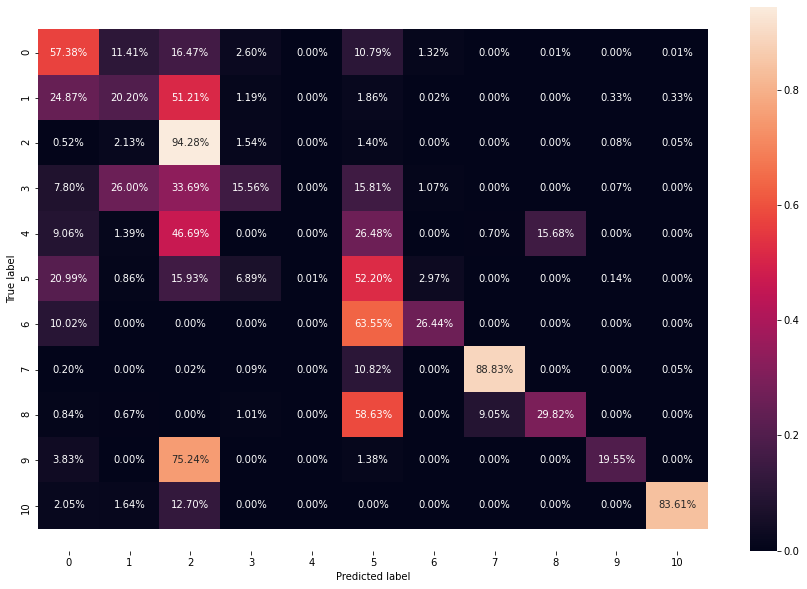

In [22]:
hidden_pred= predict(hidden_test, model)

In [ ]:
BREAK

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 13]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv=2, verbose=100, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

In [ ]:
hidden_pred= predict(hidden_test, rf_random)

In [23]:
import pickle
pickle.dump(model, open('rf.pkl', 'wb'))

# Visualization

In [24]:
#Now define a function that creates a plot with log curves, as well as a lithofacies track. 
#This plot will be flexible, in that we can provide a list of curve mnemonics that 
#we want to include in the plot.

#Now define a function that creates a plot with log curves, as well as a lithofacies track. 
#This plot will be flexible, in that we can provide a list of curve mnemonics that 
#we want to include in the plot.

def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((11*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)    
    
    

def compare_facies_plot(logs, well_name, facies_name, facies_colors, vmax):
    
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['litho_real'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['litho_pred'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(10, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.RDEP, logs.Depth, '-r')
    ax[2].plot(logs.NPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.Depth, '-', color='b')
    ax[4].plot(logs.PEF, logs.Depth, '-', color='black')
    
   
    
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=vmax)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=vmax)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((10*' ').join(facies_name))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,400)
    ax[1].set_xlabel("RDEP")
    ax[1].set_xlim(logs.RDEP.min(),logs.RDEP.max())
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel("PEF")
    ax[4].set_xlim(logs.PEF.min(),logs.PEF.max())
    ax[5].set_xlabel('litho_real')
    ax[6].set_xlabel('litho_pred')
    
   
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([]);
    
   
    f.suptitle('Well: %s' % well_name, fontsize=14,y=0.94)    


def use(data, *args):

    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.loc[:, (columns)]
    #data.fillna(data.mean(), inplace=True)
    data.fillna(0, inplace=True)
        
    return data
    
def prep(data):
    #log= ['DEPTH_MD','CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'DRHO']
    log= ['DEPTH_MD','WELL', 'GROUP', 'CALI', 'GR', 'RHOB', 'GR', 'NPHI', 'PEF', 'DRHO', 'RMED', 'RDEP']
#     data['RMED'] = outlier_removal(data['RMED'], operator.le, 0, np.nan)
#     data['GR'] = outlier_removal(data['GR'], operator.gt, 200, 200)
    
    X= use(data, *log)

    #X= precond_train(X)
    
    
    
    y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']
    #y= y.dropna(inplace=True)
    lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
    y = y.map(lithology_numbers)

    return X, y


In [25]:
wells, target = prep(hidden_test)

wells = pd.concat([wells, target, pd.Series(hidden_pred, index=target.index)], axis=1).rename(columns = {0:'pred'})
wells['actual']=wells['FORCE_2020_LITHOFACIES_LITHOLOGY']
wells

,DEPTH_MD,WELL,GROUP,CALI,GR,RHOB,GR,NPHI,PEF,DRHO,RMED,RDEP,FORCE_2020_LITHOFACIES_LITHOLOGY,pred,actual
0,1518.2800,15/9-23,HORDALAND GP.,15.506232,103.451515,0.0,103.451515,0.439925,0.0,0.109706,0.000000,0.878615,2,2,2
1,1518.4320,15/9-23,HORDALAND GP.,18.524611,94.124893,0.0,94.124893,0.504055,0.0,-0.006418,0.000000,0.874237,2,2,2
2,1518.5840,15/9-23,HORDALAND GP.,18.855669,93.586487,0.0,93.586487,0.512960,0.0,0.022769,0.000000,0.869858,2,2,2
3,1518.7360,15/9-23,HORDALAND GP.,19.163353,91.113373,0.0,91.113373,0.500070,0.0,0.024972,0.000000,0.865479,2,2,2
4,1518.8880,15/9-23,HORDALAND GP.,18.489744,100.228333,0.0,100.228333,0.277670,0.0,0.024527,0.849849,0.863804,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122392,2973.2988,35/9-7,BAAT GP.,8.276272,90.720284,0.0,90.720284,0.000000,0.0,0.502458,2.820439,3.158570,2,2,2
122393,2973.4508,35/9-7,BAAT GP.,8.267273,87.062027,0.0,87.062027,0.000000,0.0,0.374753,3.020778,3.332977,2,2,2
122394,2973.6028,35/9-7,BAAT GP.,8.250099,86.115921,0.0,86.115921,0.000000,0.0,0.211487,2.795711,3.044179,2,2,2
122395,2973.7548,35/9-7,BAAT GP.,0.000000,89.497131,0.0,89.497131,0.000000,0.0,0.147950,2.658694,2.847681,2,2,2


In [33]:
def evaluate_preds(y_true, y_preds):
    """
    Performs model evaluation  on y_true labels vs. y_pred labels and cross validation on model, X and y
    on a classification.
    """
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average= 'weighted')
    recall = recall_score(y_true, y_preds, average= 'weighted')
    f1 = f1_score(y_true, y_preds, average= 'weighted')

    
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    

In [26]:
test_wells = hidden_test['WELL'].unique()
test_wells

array(['15/9-23', '16/2-7', '16/7-6', '17/4-1', '25/10-9', '31/2-10',
       '31/2-21 S', '34/3-2 S', '35/11-5', '35/9-7'], dtype=object)

In [27]:
i =wells[wells['WELL']== '15/9-23']
ii =wells[wells['WELL']== '16/2-7']
iii =wells[wells['WELL']== '16/7-6']
iv =wells[wells['WELL']== '17/4-1']
v =wells[wells['WELL']== '25/10-9']
vi =wells[wells['WELL']== '31/2-10']
vii =wells[wells['WELL']== '31/2-21 S']
viii =wells[wells['WELL']== '34/3-2 S']
ix =wells[wells['WELL']== '35/11-5']
x =wells[wells['WELL']== '35/9-7']

In [30]:
def evaluate_well(data):
    met = evaluate_preds(data['actual'], data['pred'])
    #plot_conf_mat(data['actual'], data['pred'])

In [42]:
evaluate_well(x)

Acc: 70.56%
Precision: 0.63
Recall: 0.71
F1 score: 0.65


In [45]:
def group(logs, well_name, facies_name, facies_colors, vmax):
    
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
   
    
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
  
    ax[1].plot(logs.GROUP, logs.Depth, '-', color='y')
   
    
   
    
    

    
    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,400)
    ax[1].set_ylabel("DEPTH")

    ax[1].set_xlabel("GROUP")
    #ax[5].set_xlim(0,15)

    
    
    
   
    
    ax[1].set_yticklabels([]);
    
   
    f.suptitle('Well: %s' % well_name, fontsize=14,y=0.94)    

In [46]:
X_hid, y_hid = prep(hidden_test)

In [47]:
well = data['WELL']

lithofacies = {0: 'Sand', 1: 'SS/Shale',
               2: 'Shale', 3: 'Marl', 4: 'Dolo', 5: 'Limes', 6: 'Chalk', 7: 'Halite',
               8: 'Anhy', 9: 'Tuff',10: 'Coal'}

facies_names = lithofacies.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', 'magenta', '#000000']

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [48]:
# group_dict= {0: 0,
#             'NORDLAND GP.': 1,
#              'HORDALAND GP.': 2,
#              'ROGALAND GP.': 3, 
#              'SHETLAND GP.': 4,
#              'CROMER KNOLL GP.': 5, 
#              'VIKING GP.': 6, 
#              'BOKNFJORD GP.': 7,
#              'VESTLAND GP.': 8, 
#              'ZECHSTEIN GP.': 9,
#              'HEGRE GP.': 10, 
#              'ROTLIEGENDES GP.': 11, 
#              'TYNE GP.': 12, 
#              'DUNLIN GP.': 13, 
#              'BAAT GP.': 14}

In [49]:
group_dict= {
            'NORDLAND GP.': 'NOR',
             'HORDALAND GP.': 'HOR',
             'ROGALAND GP.': 'ROG', 
             'SHETLAND GP.': 'SHE',
             'CROMER KNOLL GP.': 'CK', 
             'VIKING GP.': 'VI', 
             'BOKNFJORD GP.': 'BON',
             'VESTLAND GP.': 'VES', 
             'ZECHSTEIN GP.': 'ZC',
             'HEGRE GP.': 'HE', 
             'ROTLIEGENDES GP.': 'ROT', 
             'TYNE GP.': 'TY', 
             'DUNLIN GP.': 'DUN', 
             'BAAT GP.': 'BAT'}

In [50]:
X_hid['GROUP']= X_hid['GROUP'].map(group_dict)
X_hid

,DEPTH_MD,WELL,GROUP,CALI,GR,RHOB,GR,NPHI,PEF,DRHO,RMED,RDEP
0,1518.2800,15/9-23,HOR,15.506232,103.451515,0.0,103.451515,0.439925,0.0,0.109706,0.000000,0.878615
1,1518.4320,15/9-23,HOR,18.524611,94.124893,0.0,94.124893,0.504055,0.0,-0.006418,0.000000,0.874237
2,1518.5840,15/9-23,HOR,18.855669,93.586487,0.0,93.586487,0.512960,0.0,0.022769,0.000000,0.869858
3,1518.7360,15/9-23,HOR,19.163353,91.113373,0.0,91.113373,0.500070,0.0,0.024972,0.000000,0.865479
4,1518.8880,15/9-23,HOR,18.489744,100.228333,0.0,100.228333,0.277670,0.0,0.024527,0.849849,0.863804
...,...,...,...,...,...,...,...,...,...,...,...,...
122392,2973.2988,35/9-7,BAT,8.276272,90.720284,0.0,90.720284,0.000000,0.0,0.502458,2.820439,3.158570
122393,2973.4508,35/9-7,BAT,8.267273,87.062027,0.0,87.062027,0.000000,0.0,0.374753,3.020778,3.332977
122394,2973.6028,35/9-7,BAT,8.250099,86.115921,0.0,86.115921,0.000000,0.0,0.211487,2.795711,3.044179
122395,2973.7548,35/9-7,BAT,0.000000,89.497131,0.0,89.497131,0.000000,0.0,0.147950,2.658694,2.847681


No of valid wells: 10


<ipython-input-45-60dc43ac49b0>:24: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


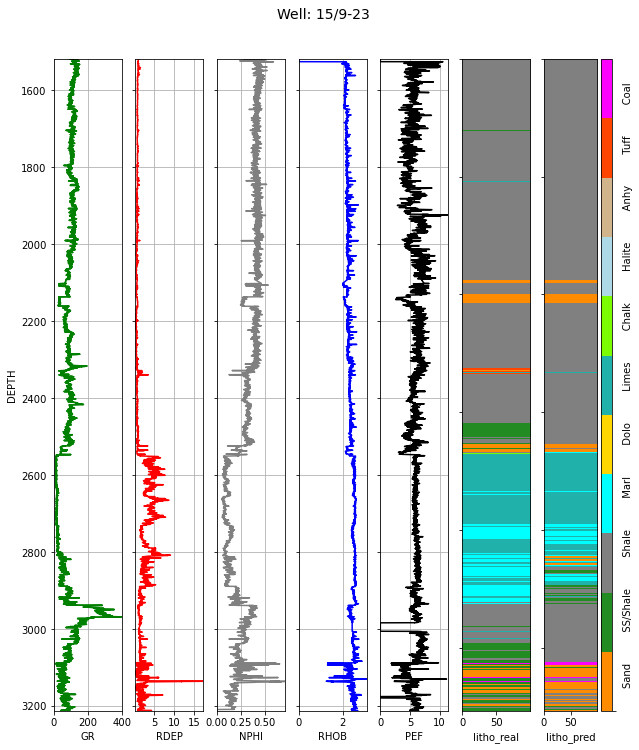

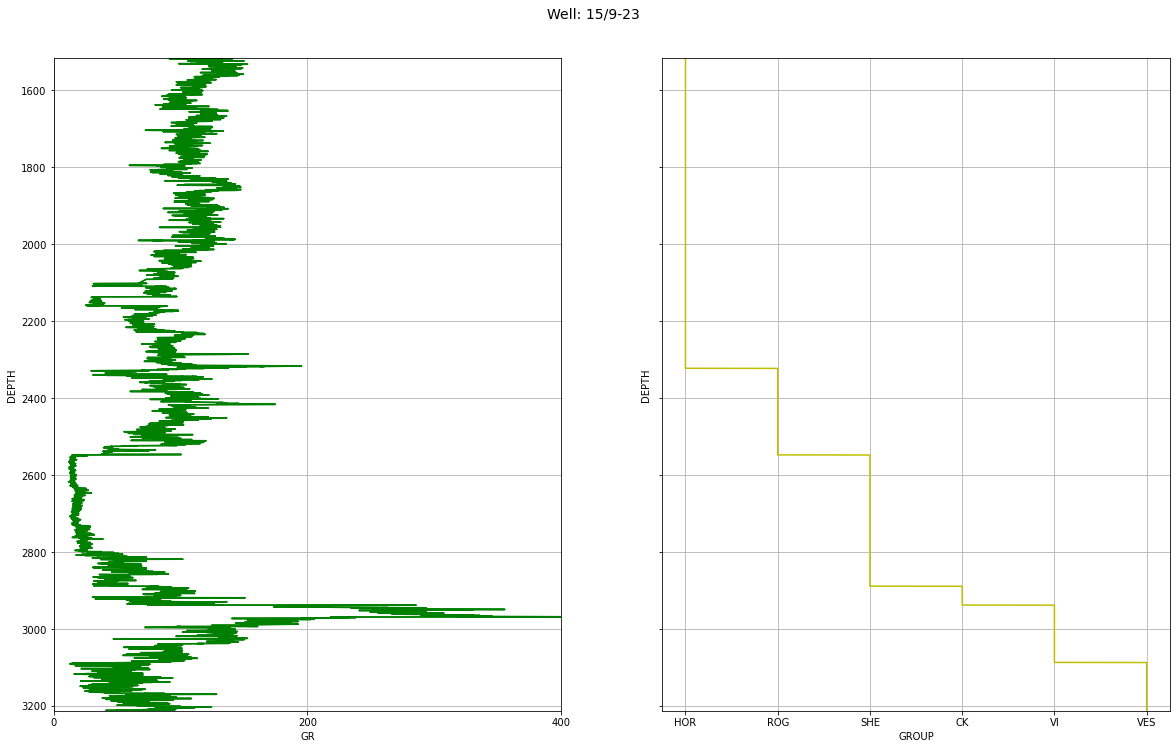

In [51]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


print('No of valid wells: %s' % len(test_wells))
well_no=5
log = pd.concat([X_hid, 
                  y_hid], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })


logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '15/9-23']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '15/9-23', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '15/9-23', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

In [ ]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '16/2-7']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '16/2-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '16/2-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

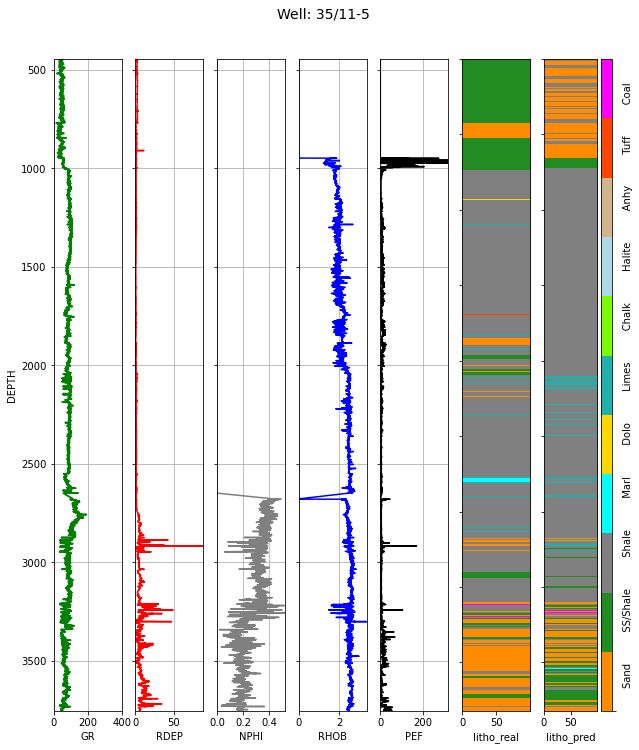

In [53]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '35/11-5']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '35/11-5', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-24-70ac2645a8f5>:110: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax[4].set_xlim(logs.PEF.min(),logs.PEF.max())
<ipython-input-45-60dc43ac49b0>:24: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


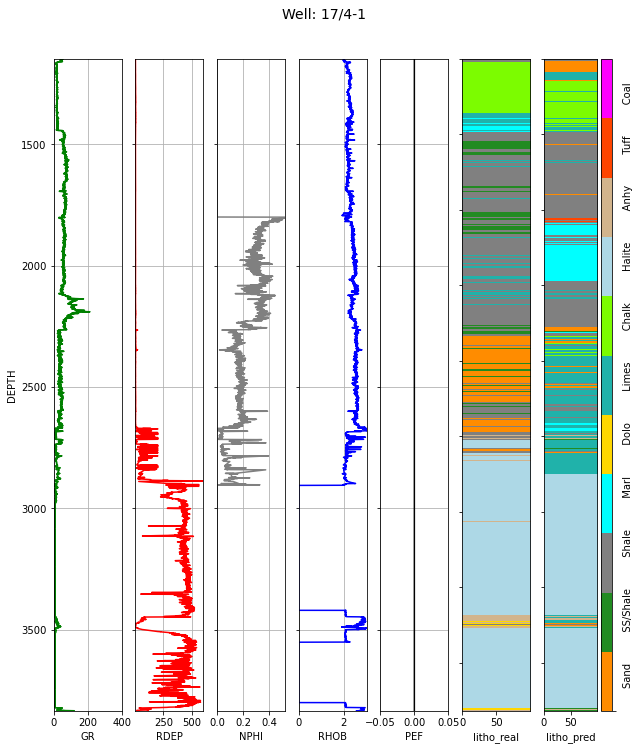

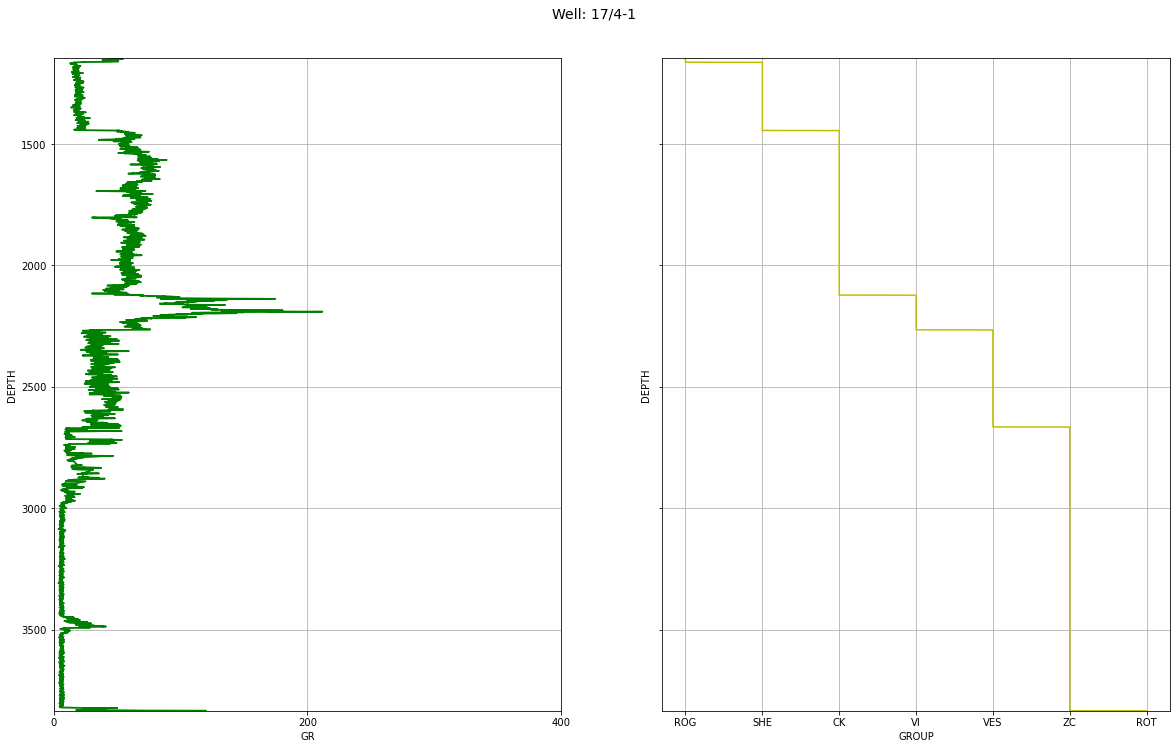

In [54]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '17/4-1']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '17/4-1', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '17/4-1', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

In [ ]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '16/7-6']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '16/7-6', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '16/7-6', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-45-60dc43ac49b0>:24: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


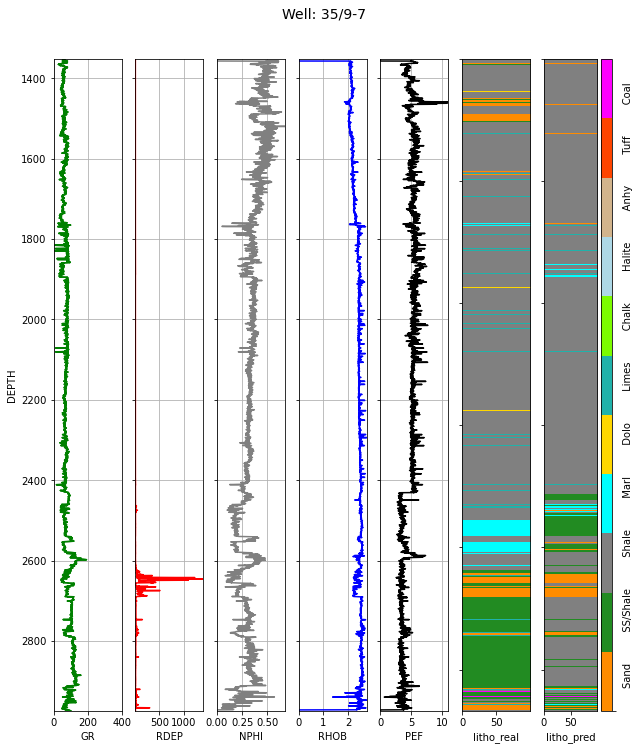

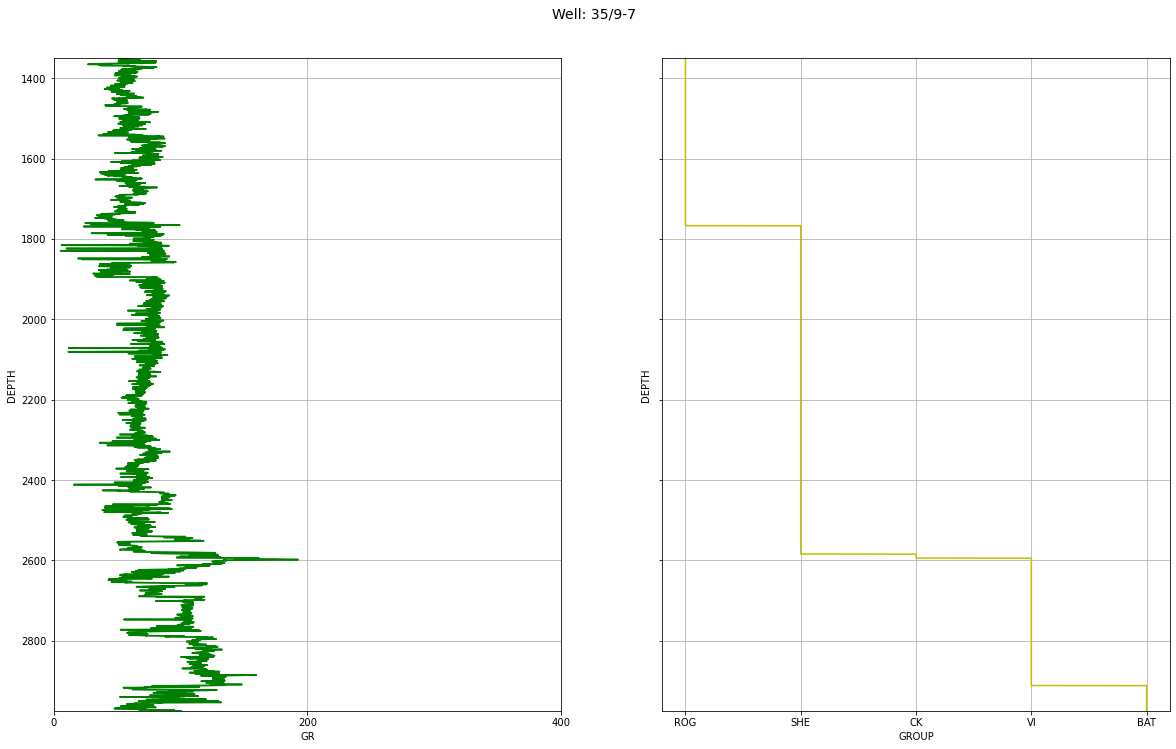

In [58]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '35/9-7']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '35/9-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '35/9-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-45-60dc43ac49b0>:24: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


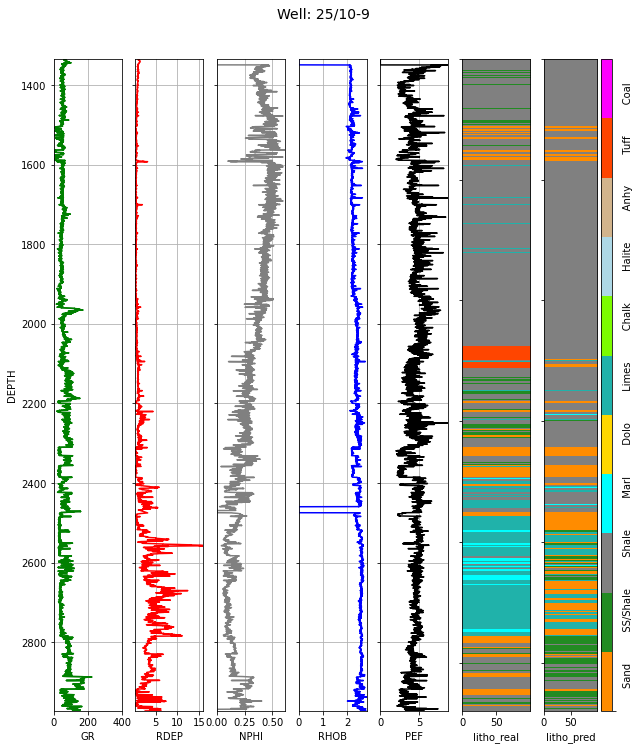

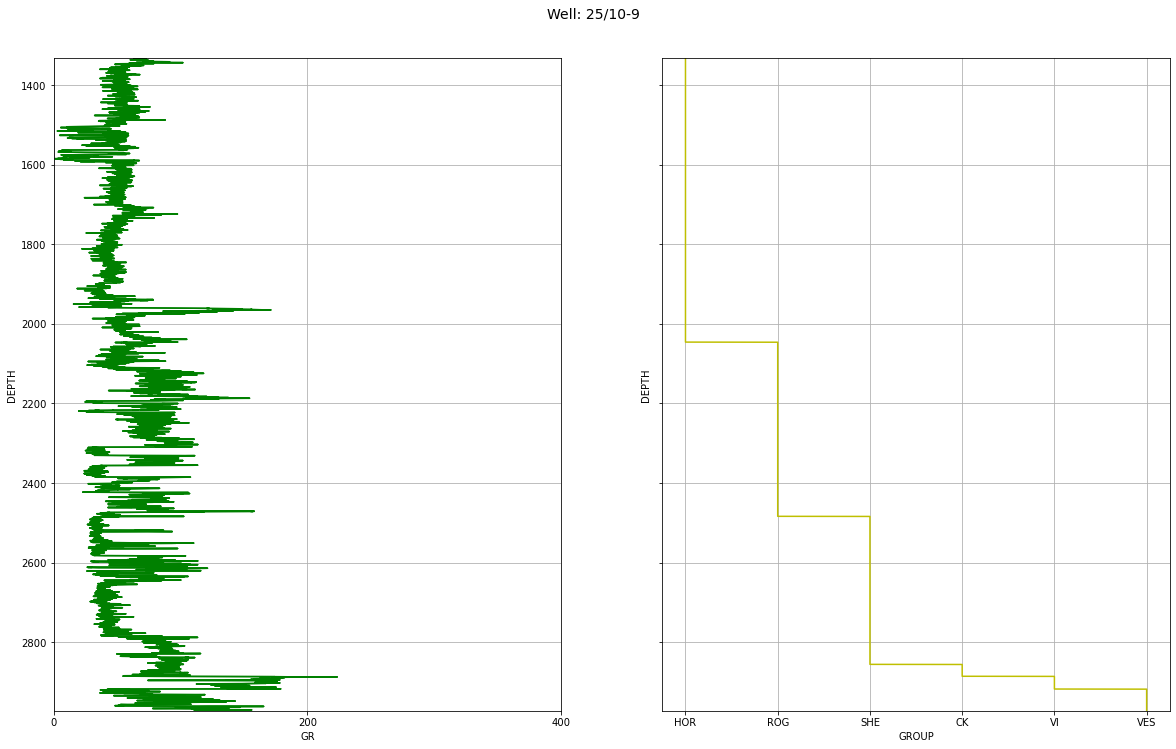

In [55]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '25/10-9']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '25/10-9', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '25/10-9', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

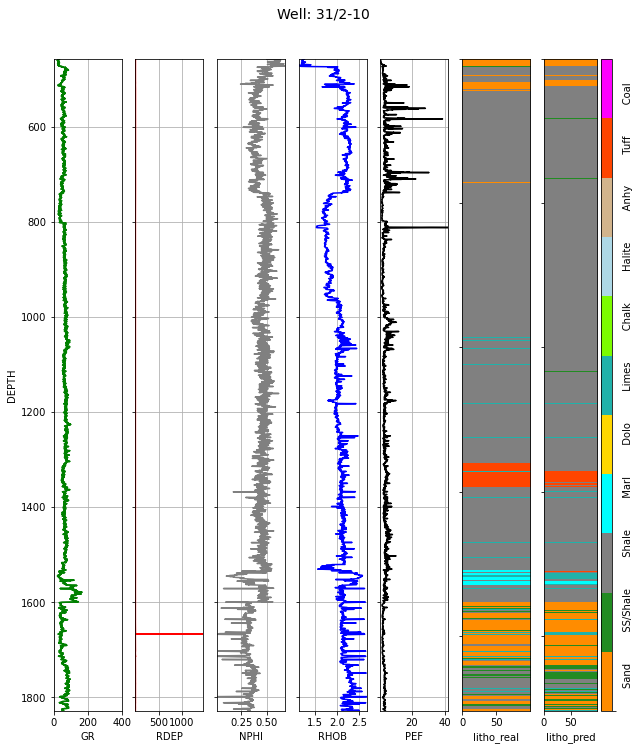

In [52]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '31/2-10']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '31/2-10', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))


In [ ]:
test_wells

<ipython-input-45-60dc43ac49b0>:24: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


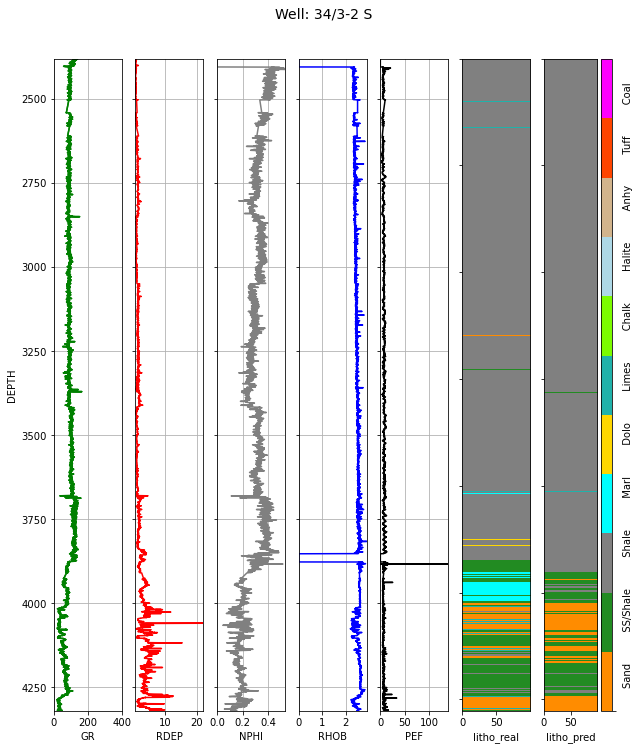

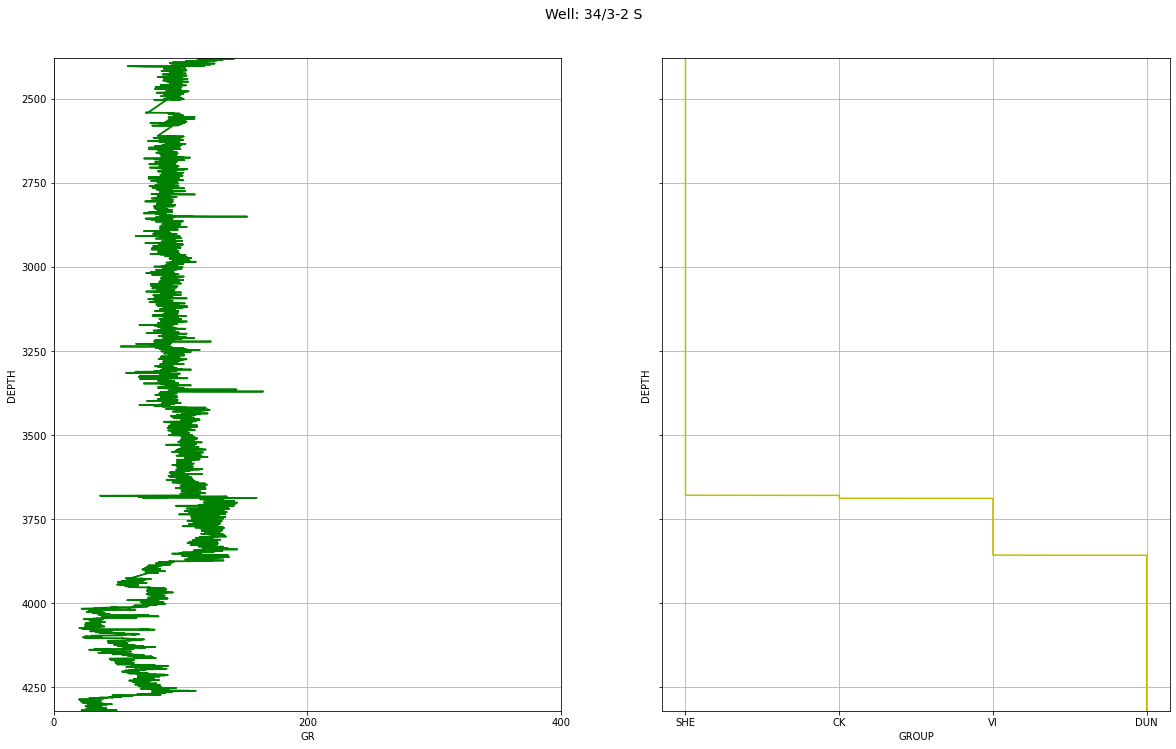

In [57]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '34/3-2 S']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '34/3-2 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '34/3-2 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-45-60dc43ac49b0>:24: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


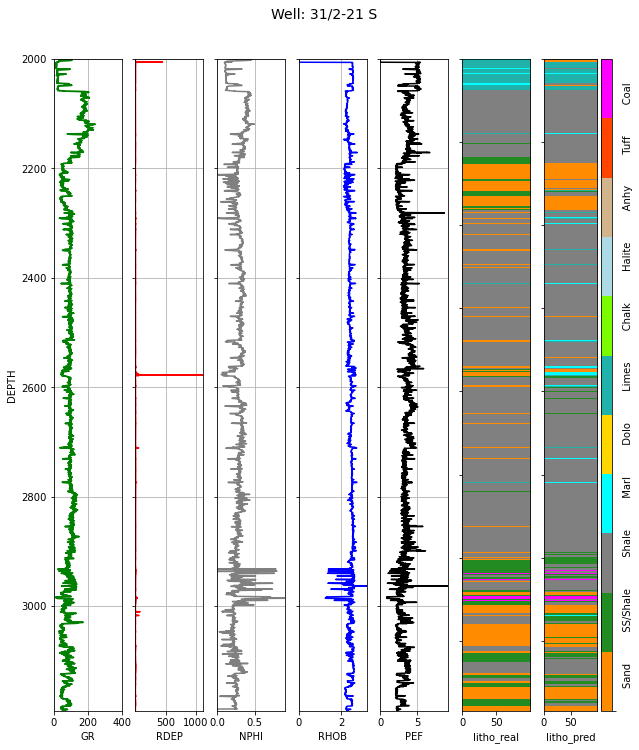

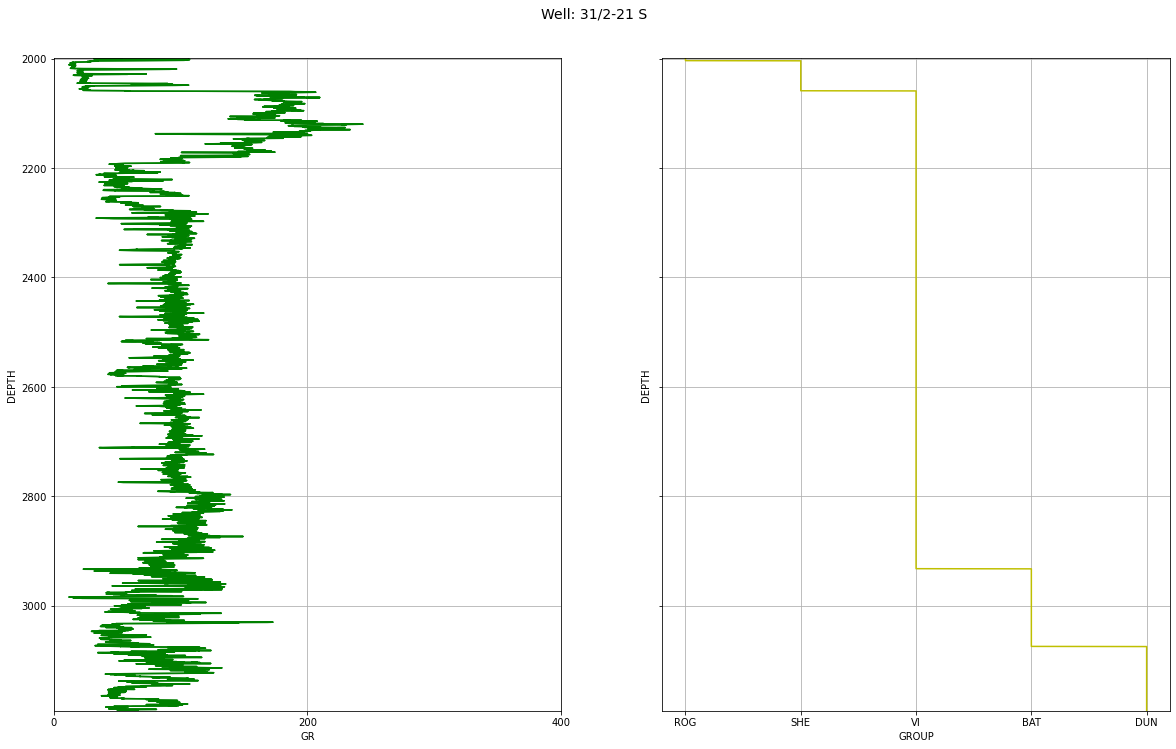

In [56]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '31/2-21 S']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '31/2-21 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '31/2-21 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

## Break

In [ ]:
train_well = data['WELL'].unique()

X_train, y_train =prep(data)

lithofacies = {0: 'Sandstone', 1: 'Sandstone/Shale',
               2: 'Shale', 3: 'Marl', 4: 'Dolomite', 5: 'Limestone', 6: 'Chalk', 7: 'Halite',
               8: 'Anhydrite', 9: 'Tuff',10: 'Coal', 11: 'Basement'}

facies_names = lithofacies.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [ ]:
print('No of train wells: %s' % len(train_well))

In [ ]:
well_no=70
logs = pd.concat([X_train, 
                  y_train], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_well[well_no]], ['CALI', 'GR', 'RHOB', 'NPHI'],
                     train_well[well_no],
                     facies_colors)

In [ ]:
well_no=30
logs = pd.concat([X_train, 
                  y_train], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_well[well_no]], ['CALI', 'GR', 'RHOB', 'NPHI'],
                     train_well[well_no],
                     facies_colors)

In [ ]:
fig = plt.figure(figsize=(15, 10))
train["FORCE_2020_LITHOFACIES_LITHOLOGY"].value_counts().plot(kind="bar",  color=["g"]);